In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import fft, ifft, fftfreq

# Funkcja do ładowania obrazu
def load_image(file_path):
    image = Image.open(file_path).convert('L')
    return np.array(image, dtype=np.float32)

# Funkcja transformacji Radona
def radon_transform(image, delta_alpha, n_detectors, spread):
    h, w = image.shape
    angles = np.deg2rad(np.arange(0, 180, delta_alpha))
    s = np.linspace(-spread/2, spread/2, n_detectors)
    sinogram = np.zeros((len(angles), n_detectors))
    
    center_x, center_y = w // 2, h // 2
    max_length = int(np.sqrt(h**2 + w**2))  # Długość przekątnej obrazu
    
    for i, theta in enumerate(angles):
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        
        for j, s_val in enumerate(s):
            line_sum = 0.0
            for t in np.linspace(-max_length/2, max_length/2, max_length):
                x = int(np.round(center_x + s_val * cos_t + t * (-sin_t)))
                y = int(np.round(center_y + s_val * sin_t + t * cos_t))
                
                if 0 <= x < w and 0 <= y < h:
                    line_sum += image[y, x]
            
            sinogram[i, j] = line_sum
    
    return sinogram
#Filtr Ram-Lak
def apply_filter(sinogram):
    n = sinogram.shape[1]
    freqs = fftfreq(n).reshape(1, -1)
    filter_kernel = np.abs(freqs * n)  
    
    sinogram_fft = fft(sinogram, axis=1)
    filtered_sinogram = np.real(ifft(sinogram_fft * filter_kernel, axis=1))
    
    return filtered_sinogram

#Filtr Shepp-Logan
def apply_filter1(sinogram):
    n = sinogram.shape[1]
    freqs = fftfreq(n)
    ramp = np.abs(freqs * n)
    window = np.sinc(freqs * 0.5)     
    filt = ramp * window

    sinogram_fft = fft(sinogram, axis=1)
    return np.real(ifft(sinogram_fft * filt, axis=1))

# Funkcja odwrotnej transformacji Radona
def inverse_radon_transform(sinogram, delta_alpha, n_detectors, spread):
    h = w = sinogram.shape[1]
    reconstructed = np.zeros((h, w))
    angles = np.deg2rad(np.arange(0, 180, delta_alpha))
    center = w // 2
    
    # Obliczenia parametrów detektora
    detector_spacing = spread / (n_detectors - 1) if n_detectors > 1 else 1
    s_center = (n_detectors - 1) / 2  # Środek w przestrzeni detektorów

    for i, theta in enumerate(angles):
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        
        for x in range(w):
            for y in range(h):
                # Obliczenie współrzędnych w przestrzeni Radona
                s = (x - center) * cos_t + (y - center) * sin_t
                
                # Przeliczenie na indeks detektora z interpolacją
                s_idx = s / detector_spacing + s_center
                
                if 0 <= s_idx < n_detectors:
                    # Interpolacja liniowa
                    j = int(np.floor(s_idx))
                    a = s_idx - j
                    if j < n_detectors - 1:
                        reconstructed[y, x] += (1 - a) * sinogram[i, j] + a * sinogram[i, j+1]
                    else:
                        reconstructed[y, x] += sinogram[i, j]

    return reconstructed * np.pi / (2 * len(angles))

# Funkcja do przetwarzania obrazu
def process_image(file_path, delta_alpha, n_detectors, spread):
    image_array = load_image(file_path)
    sinogram = radon_transform(image_array, delta_alpha, n_detectors, spread)

    filtered_sinogram = apply_filter(sinogram)
    filtered_sinogram1 = apply_filter1(sinogram)

    # Rekonstrukcje z poprawionymi parametrami
    reconstructed_image_without_filter = inverse_radon_transform(sinogram, delta_alpha, n_detectors, spread)
    reconstructed_image = inverse_radon_transform(filtered_sinogram, delta_alpha, n_detectors, spread)
    reconstructed_image_second = inverse_radon_transform(filtered_sinogram1, delta_alpha, n_detectors, spread)
    
    # Wizualizacja
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    
    axs[0,0].imshow(image_array, cmap='gray')
    axs[0,0].set_title("Oryginalny obraz")

    axs[0,1].imshow(sinogram, cmap='gray')
    axs[0,1].set_title("Sinogram")

    axs[0,2].imshow(filtered_sinogram, cmap='gray')
    axs[0,2].set_title("Filtr Ram-Lak")

    axs[0,3].imshow(filtered_sinogram1, cmap='gray')
    axs[0,3].set_title("Filtr Shepp-Logan")

    axs[1,0].imshow(reconstructed_image_without_filter, cmap='gray')
    axs[1,0].set_title("Bez filtru")

    axs[1,1].imshow(reconstructed_image, cmap='gray')
    axs[1,1].set_title("Rekonstrukcja Ram-Lak")

    axs[1,2].imshow(reconstructed_image_second, cmap='gray')
    axs[1,2].set_title("Rekonstrukcja Shepp-Logan")

    axs[1,3].axis('off')

    plt.tight_layout()
    plt.show()

Uruchamianie na różnych obrazach

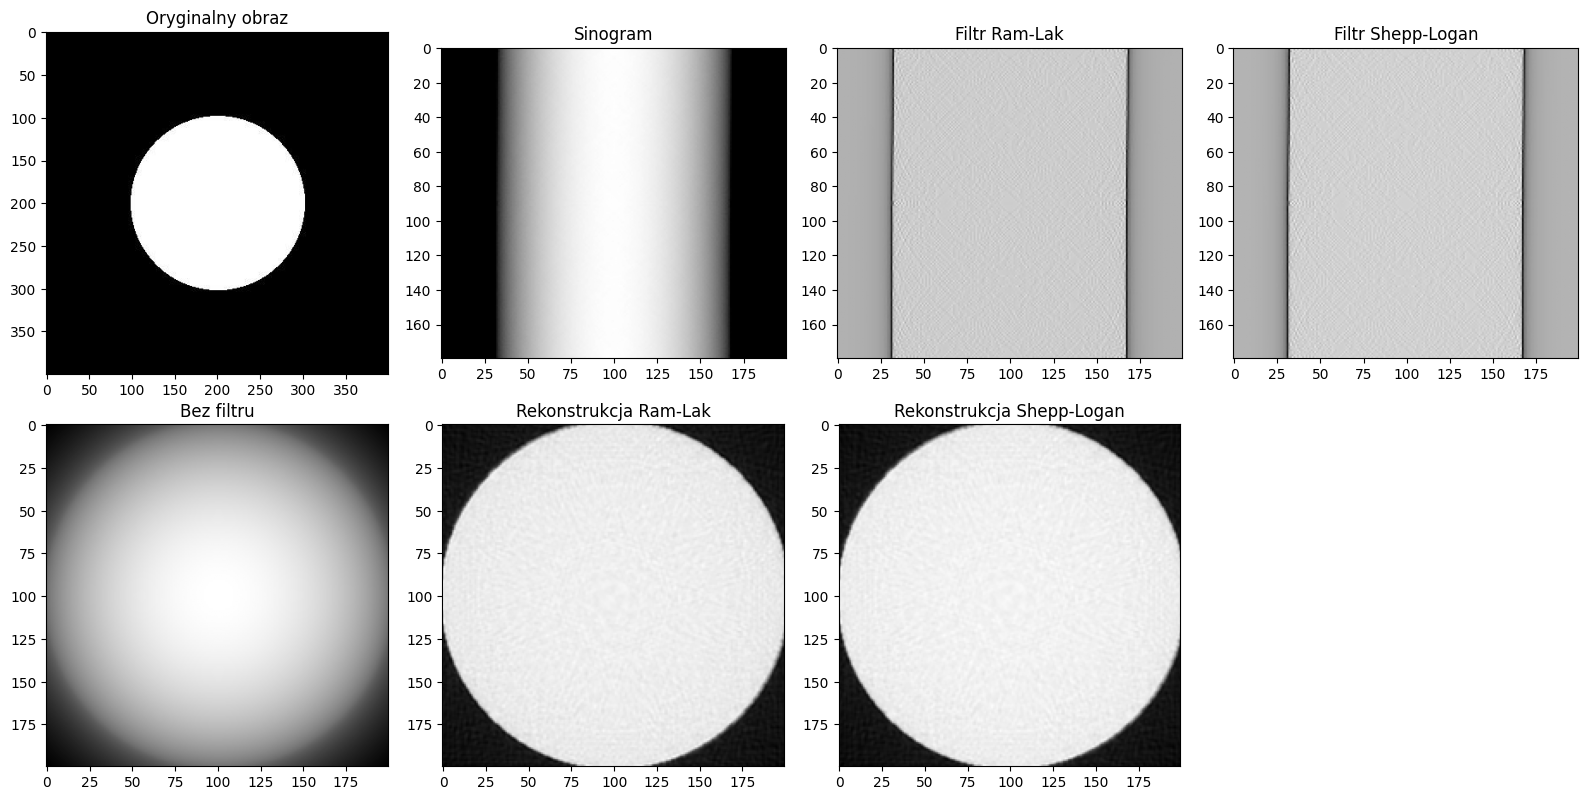

In [41]:
file_path = "tomograf-obrazy/Kolo.jpg"
process_image(file_path, delta_alpha=1, n_detectors=200, spread=300)

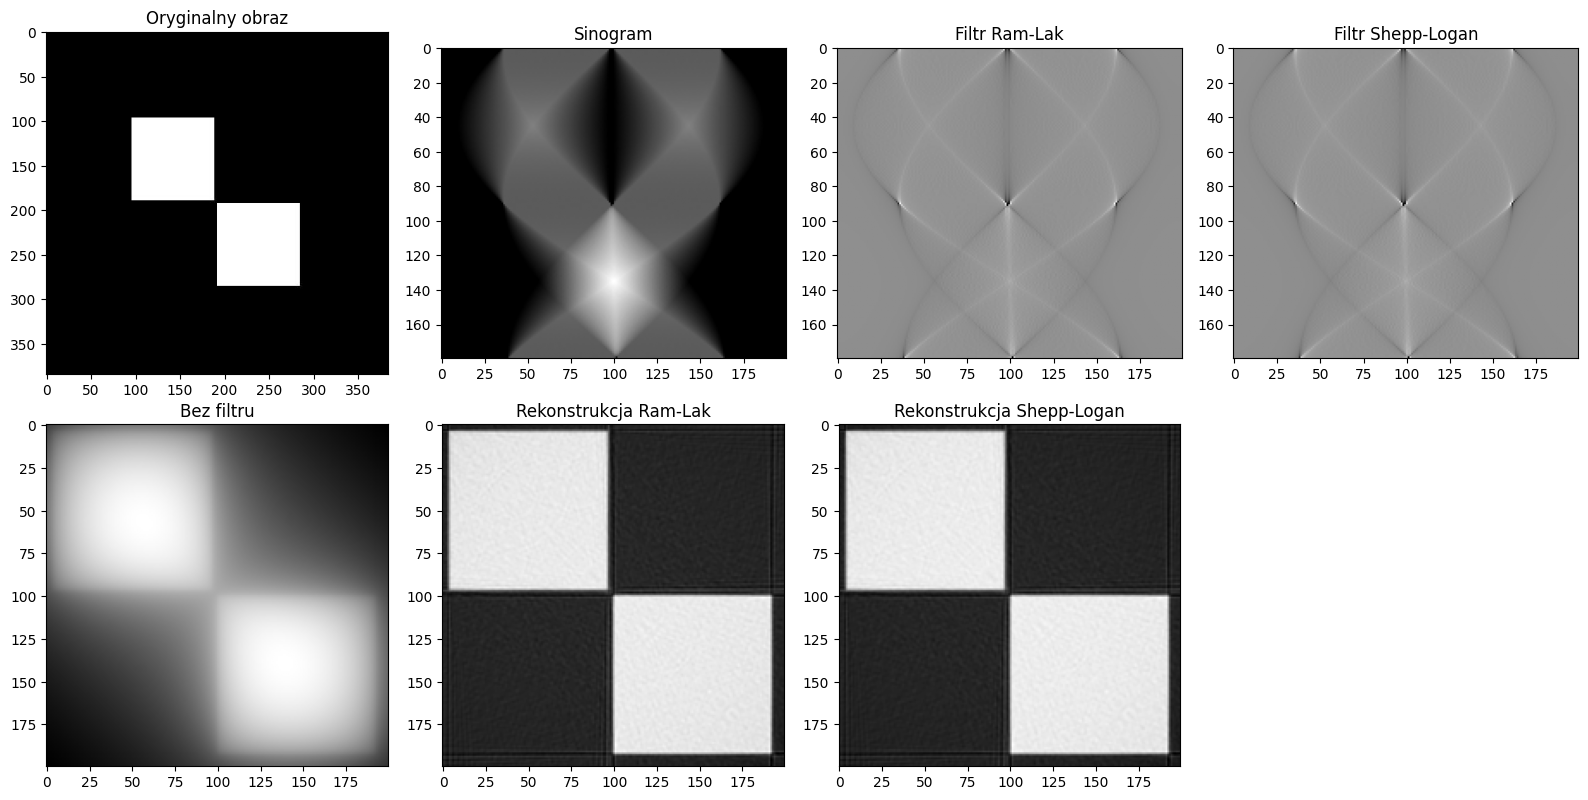

In [42]:
file_path = "tomograf-obrazy/Kwadraty2.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

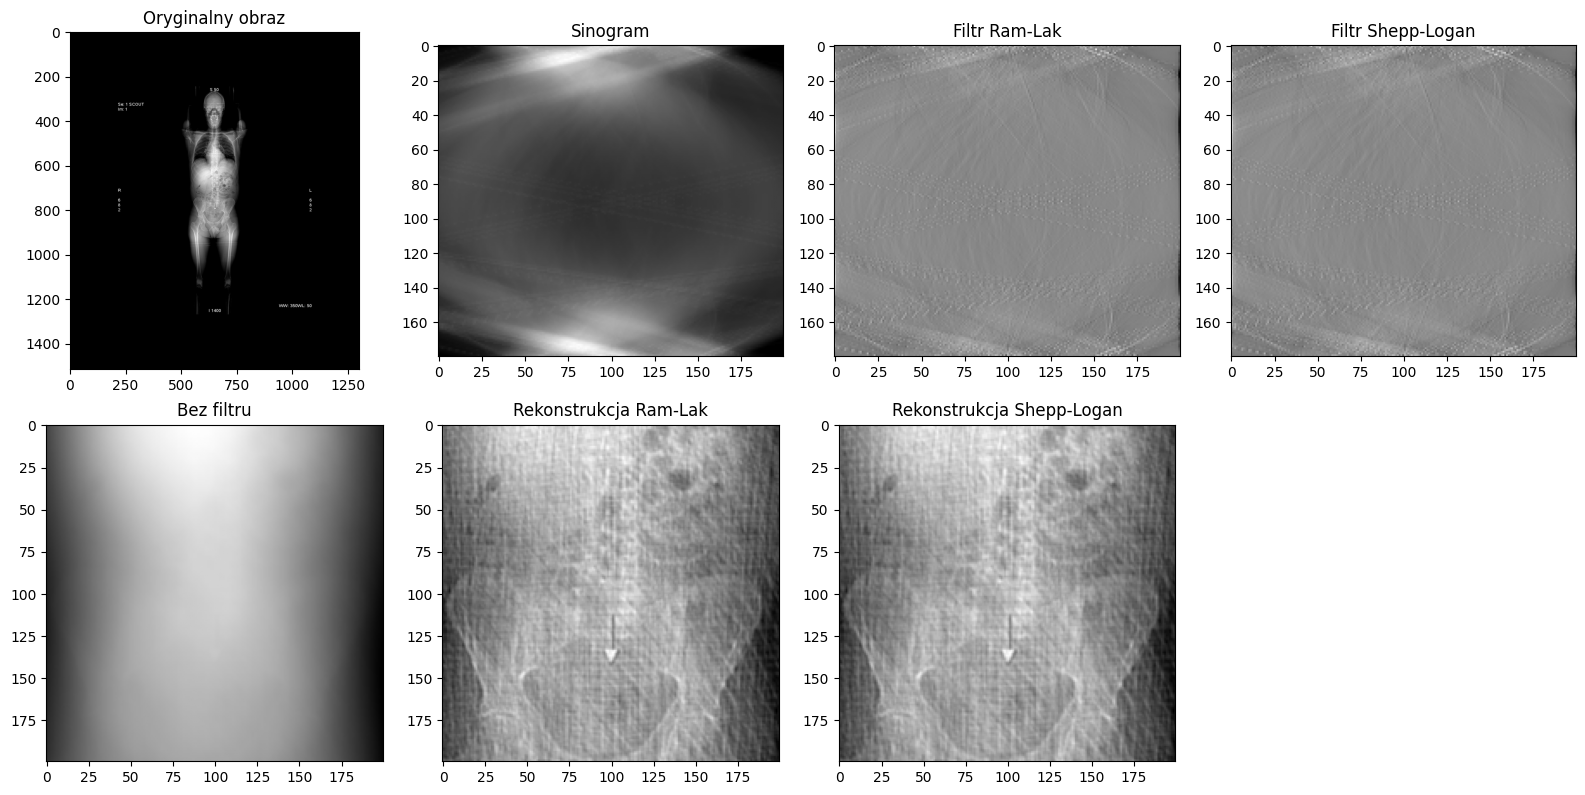

In [43]:
file_path = "tomograf-obrazy/CT_ScoutView-large.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

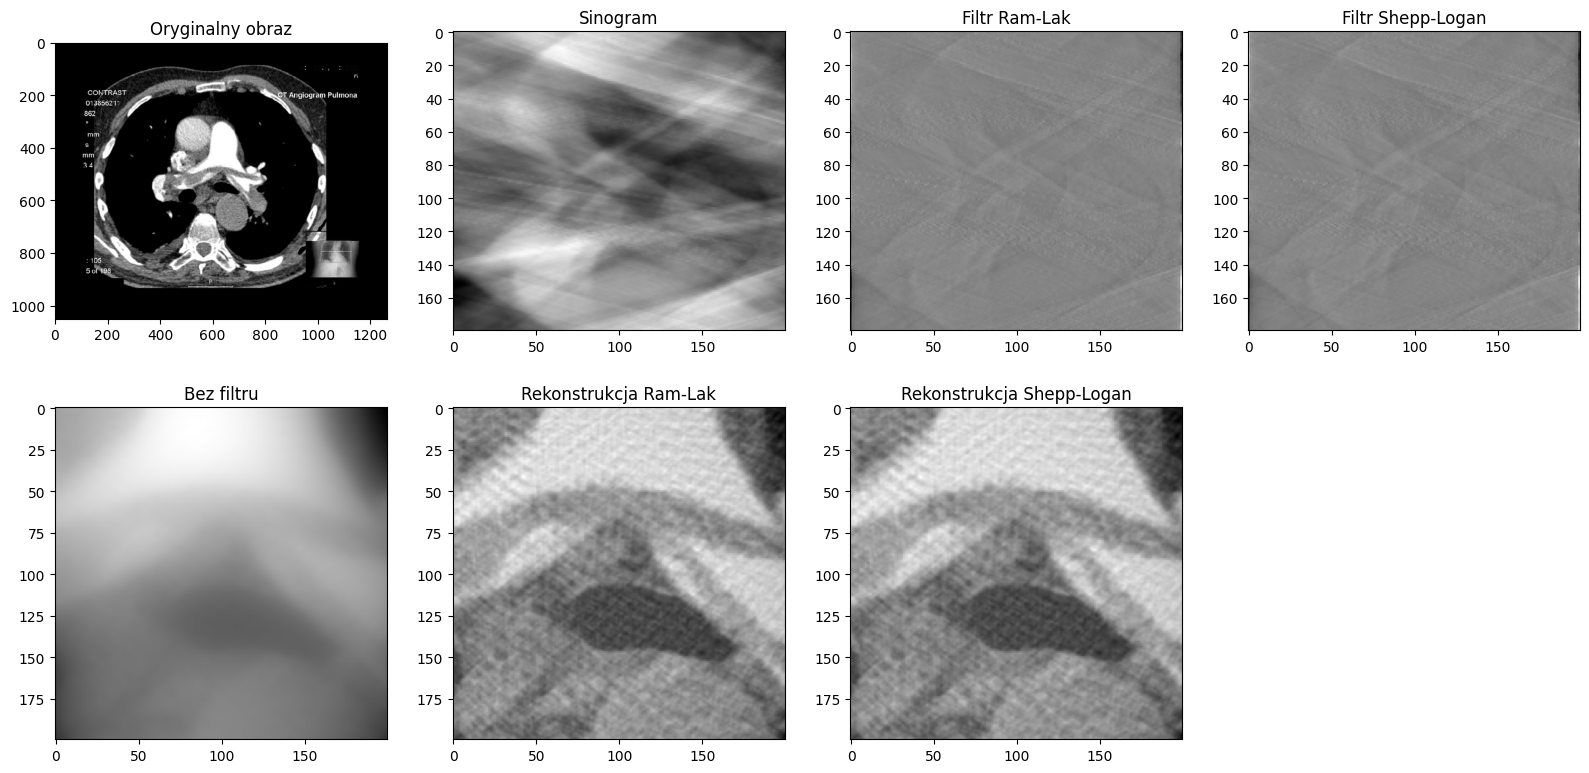

In [44]:
file_path = "tomograf-obrazy/SADDLE_PE-large.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)

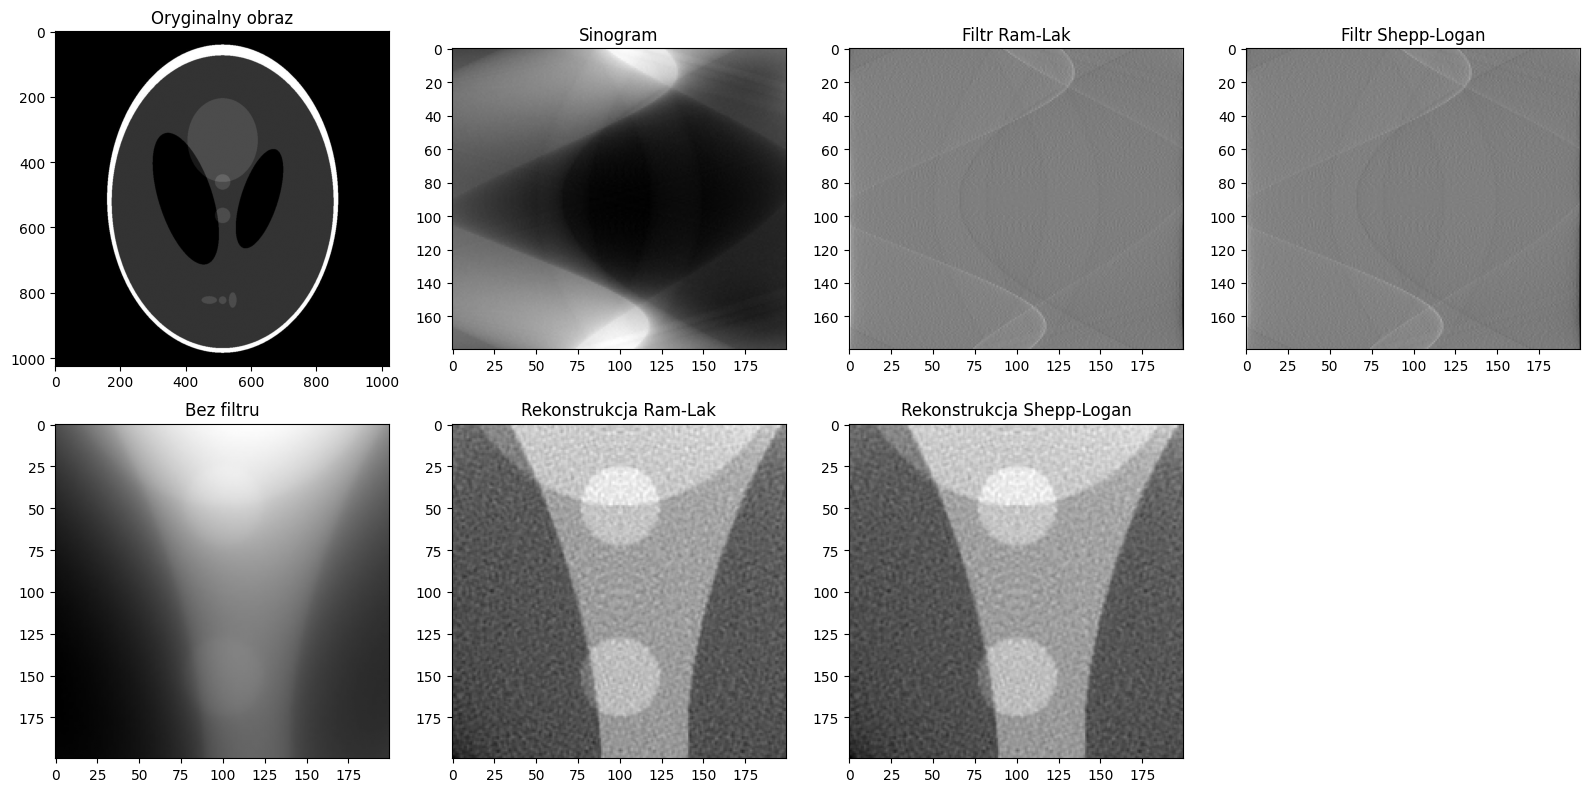

In [45]:
file_path = "tomograf-obrazy/Shepp_logan.jpg"
process_image(file_path, delta_alpha=1.0, n_detectors=200, spread=300)